# Jack's car rental
__Original problem__: Jack manages two locations for a nationwide car rental company. Each day, some number of customers arrive at each location to rent cars. If Jack has a car available, he rents it out and is credited \$10 by the national company. If he is out of cars at that location, then the business is lost. Cars become available for renting the day after they are returned. To help ensure that cars are available where they are needed, Jack can move them between the two locations overnight, at a cost of \$2 per car moved. We assume that the number of cars requested and returned at each location are Poisson random variables, meaning that the probability that the number is n is $\frac {λ ^ {n}}{n!} e^{-λ}$, where λ is the expected number. Suppose λ is 3 and 4 for rental requests at the first and second locations and 3 and 2 for returns. To simplify the problem slightly, we assume that there can be no more than 20 cars at each location (any additional cars are returned to the nationwide company, and thus disappear from the problem) and a maximum of five cars can be moved from one location to the other in one night. We take the discount rate to be γ = 0.9 and formulate this as a continuing finite MDP, where the time steps are days, the state is the number of cars at each location at the end of the day, and the actions are the net numbers of cars moved between the two locations overnight

__Modified version__: One of Jack’s employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs $2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of $4 must be incurred to use a second parking lot (independent of how many cars are kept there)

## Solution: 
*Optimisation*: This approach is incredibly fast (about 3.3s) with the following optimisation approach:
1. Cache transition probabilities for two stores, and the expected rewards to avoid repeated computation.
2. Use numpy matrix to represent transtional probability matrix.
3. Use numpy iterator for faster iterating over matrix. 
4. We assume that bad actions are the one that move cars from one place to another such that the number of cars exceed 20 or less than 0.

In [ ]:
import numpy as np
import copy
from scipy.stats import poisson
class mdp:
    def __init__(self):
        self.state_space = np.array([(i, j) for i in range(21) for j in range(21)])
        self.action_space = np.array([i for i in range(-5, 6)])
        self.policy = np.zeros(shape=(21,21), dtype=int)
        self.value = np.zeros(shape=(21,21), dtype=int)

        self.request1 = self.poisson_prob(3)
        self.return1 = copy.deepcopy(self.request1)
        self.request2 = self.poisson_prob(4)
        self.return2 = self.poisson_prob(2)

        self.transition_s1 = np.outer(self.return1, self.request1) 
        self.transition_s2 = np.outer(self.return2, self.request2)

        self.reward_s1 = np.zeros(21)
        self.reward_s2 = np.zeros(21)

        self.gamma = 0.9
        self.epsilon = 0.01

    def poisson_prob(self, mu):
        arr = np.array([poisson.pmf(i, mu) for i in range(21)])
        arr[-1] += poisson.sf(20, mu)
        return arr

    def bellman(self, action, s1, s2):
        cost = abs(action) * 2
        transp = self.transition_probabilty(s1, s2, action)
        reward_s1, reward_s2 = self.expected_reward(s1, s2, action)
        return reward_s1 + reward_s2 - cost + self.gamma * sum((transp * self.value).flat)

    def expected_reward(self, s1, s2, action):
        s1_prime = s1 - action
        s2_prime = s2 + action
        if self.reward_s1[s1_prime] == 0:
            self.reward_s1[s1_prime] = 10 * np.dot(np.arange(s1_prime + 1), self.request1[:s1_prime + 1])
        if self.reward_s2[s2_prime] == 0:
            self.reward_s2[s2_prime] = 10 * np.dot(np.arange(s2_prime + 1), self.request1[:s2_prime + 1])
        return self.reward_s1[s1_prime], self.reward_s2[s2_prime]
    
    def transition_probabilty(self, s1, s2, action):
        s1_prime = s1 - action
        s2_prime = s2 + action
        trans_mat1 = copy.deepcopy(self.transition_s1[:, :s1_prime + 1])
        trans_mat2 = copy.deepcopy(self.transition_s2[:, :s2_prime + 1])
        p1 = np.asarray([np.trace(trans_mat1, i) for i in range(-s1_prime, 21 - s1_prime)])
        p2 = np.asarray([np.trace(trans_mat2, i) for i in range(-s2_prime, 21 - s2_prime)])
        return np.outer(p1, p2)
    
    def policy_evaluation(self):
        while True:
            diff = 0.
            it = np.nditer([self.policy], flags=['multi_index'])

            while not it.finished:
                action = it[0]
                s1, s2 = it.multi_index

                temp = self.value[s1, s2]

                self.value[s1, s2] = self.bellman(action=action, s1=s1, s2=s2)

                diff = max(diff, abs(self.value[s1, s2] - temp))

                it.iternext()

            if diff < self.epsilon:
                break
    
    def policy_improvement(self):
        better_policy = copy.deepcopy(self.policy)
        it = np.nditer([self.policy], flags=['multi_index'])
        while not it.finished:
            s1, s2 = it.multi_index
            best_val = 0
            best_act = 0
            for act in self.action_space:
                if (s1 >= act) and (s2 >= -act) and (s1 <= 20 + act) and (s2 <= 20 - act):
                    temp = self.bellman(act, s1, s2)
                    if temp > best_val:
                        best_val = temp
                        best_act = act

            better_policy[s1, s2] = best_act
            it.iternext()
            
        return better_policy

    def policy_iteration(self):
        cnt = 0
        while True:
            print(cnt)
            self.values = self.policy_evaluation()
            better_policy = self.policy_improvement()
            if np.array_equal(self.policy, better_policy):
                break
            self.policy = copy.deepcopy(better_policy)
            cnt += 1

In [64]:
game = mdp()    
game.policy_iteration()

0
1
2
3


In [46]:
game.policy

array([[ 0,  0,  0,  0,  0,  0, -2, -3, -4, -4, -5, -5, -5, -5, -5, -5,
        -5, -5, -5, -5, -5],
       [ 0,  1,  1,  1,  1, -1, -2, -3, -3, -4, -4, -4, -5, -5, -5, -5,
        -5, -5, -5, -5, -5],
       [ 0, -1,  2,  0,  0, -1, -2, -2, -3, -3, -3, -4, -4, -5, -5, -5,
        -5, -5, -5, -5, -5],
       [ 0, -1,  0,  0,  0, -1, -1, -2, -2, -2, -3, -3, -4, -4, -5, -5,
        -5, -5, -5, -5, -5],
       [ 0, -1,  1,  1,  0,  0, -1, -1, -1, -2, -2, -3, -3, -4, -4, -5,
        -5, -5, -5, -5, -5],
       [ 0,  2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -2, -3, -3, -4, -4,
        -5, -5, -5, -5, -5],
       [ 3,  3,  2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -2, -3, -3, -4,
        -5, -5, -5, -5, -5],
       [ 4,  3,  3,  2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -2, -3, -4,
        -4, -5, -5, -5, -5],
       [ 4,  4,  3,  3,  2,  2,  1,  1,  0,  0,  0, -1, -1, -2, -3, -3,
        -4, -5, -5, -5, -5],
       [ 5,  4,  4,  3,  3,  2,  2,  1,  0,  0,  0,  0, -1, -2, -2, -3,
        -4, -5, -5,

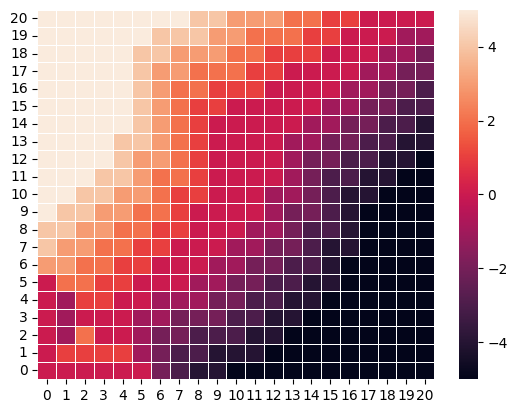

In [47]:
import seaborn as sns
ax = sns.heatmap(game.policy, linewidth=0.5)
ax.invert_yaxis()

In [59]:
class modified_mdp(mdp):
    def __init__(self):
        super().__init__()
    
    def gen_cost(self, action, s1, s2):
        cost = 0
        if action > 0:
            cost = (action - 1) * 2
        elif action < 0:
            cost = abs(action) * 2
        if (s1 - action) > 10:
            cost += 10
        if (s2 + action) > 10:
            cost += 10
        return cost
    
    def bellman(self, action, s1, s2):
        cost = self.gen_cost(action, s1, s2)
        transp = self.transition_probabilty(s1, s2, action)
        reward_s1, reward_s2 = self.expected_reward(s1, s2, action)
        return reward_s1 + reward_s2 - cost + self.gamma * sum((transp * self.value).flat)

In [60]:
modified_game = modified_mdp()
modified_game.policy_iteration()

0
1
2
3


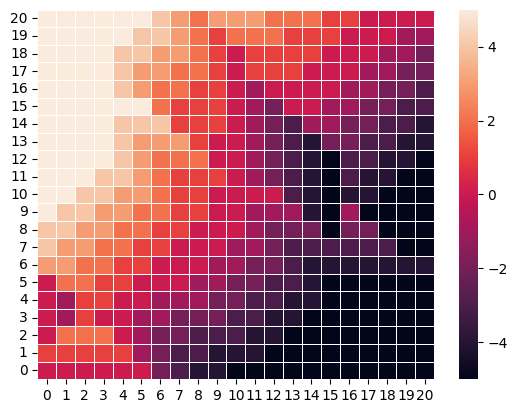

In [62]:
ax = sns.heatmap(modified_game.policy, linewidth=0.5)
ax.invert_yaxis()